## Transporte de um pulso inicial de poluição numa situação em que o vento seja constante
 Alejandro Delgado Peralta


In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Exercicio com aproximação de primeiro ordem, progressivo no tempo e regressivo no espaço.
Temos uma equação da adveção em 1D:

$$
\frac{\partial C}{\partial t} + U*\frac{\partial C}{\partial x} = 0,
$$

A condição inicial (CI) dada por uma gaussiana centrada em i=51, com decaimiento exponencial dado por `nr` (número de pontos) onde a amplitude da perturbação cai de um fator e:

$$
C(x,0) = C_{i,0} = C_0 \exp[\frac{-(i\Delta x - 51\Delta x)^2}{(nr*\Delta x)^2}]
$$

CFL:
$$
U*\frac{\Delta t}{\Delta x} < 1
$$

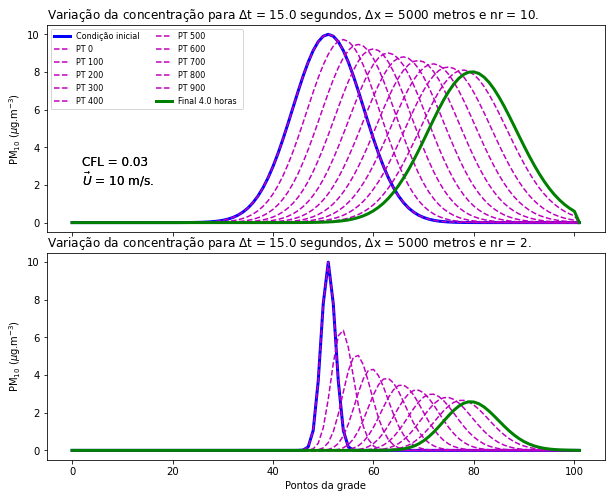

In [58]:
# Condições do exercicío 1
# ------------------------------------------------------
Nx     = 101            # pontos totais da malha 1D
dx     = 5000           # espaçamento uniforme
Tempo  = 4*3600         # tempo total em segundos
#dt     = dx/U_wind      # para ter CFL = 1
dt     = 3*dx/1000      # passo de tempo , 6*dx/1000 baseado na recomendação WRF-Chem
Nt     = int(Tempo/dt)  # número de passos de tempo
U_wind = +10             # vento zonal m/s
Co     = 10             # ug/m3 em PM10

CFL = U_wind*dt/dx

# Condição inicial 
# ------------------------------------------------------
## Condição de fronteira fixa 0
C = np.zeros((Nx+1,Nt+1))

def Conc(i,nr):
    """
    Função de concentração com variação Gaussiana
    i:  index
    nr: número de pontos a partir do centro da gaussiana
    dx: variação espacial em metros.
    Co: Concentração do poluente 
    """
    Conc = Co*np.exp(-(i*dx-51*dx)**2/(nr*dx)**2)

    return Conc

def Ret(i, nr):
    pass

# Figuras
# ----------------------------------------------------------
fig, ax = plt.subplots(2,1, figsize=[10,8], sharex = True, gridspec_kw={'hspace':0.1} )
for j, nr in enumerate([10, 2]):
    for i in range(Nx+1):
        C[i,0] = Conc(i,nr)

    # Condição de fronteira fixa
    C[[0,-1],0] = [0,0]

    # Aproximação primeiro ordem progressivo no tempo e regressivo no espaço
    # ----------------------------------------------------------------------
    ax[j].plot(C[:,0], color = 'b', lw=3, label="Condição inicial")

    for n in range(0, Nt):
        # Condição de fronteira fixa
        C[[0,-1],n] = [0,0]
    
        if n % 100 == 0:
            ax[j].plot(C[:,n], color='m', linestyle='dashed', label=f"PT {n}")     

        for i in range(1,Nx):
        
            # depende do termo vento e nr para que fique inestável, U é positivo
            C[i,n+1] = C[i, n] - U_wind*dt/dx*(C[i, n]- C[i-1, n]) 

    ax[j].plot(C[:,-1], color='g', lw=3, label = f"Final {Tempo/3600} horas ")

    ax[j].set_ylabel("PM$_{10}$ ($\mu$g.m$^{-3}$)")
    ax[0].text(2,2, r"$\vec U$ = "+ f"{U_wind} m/s.", fontsize=12)
    ax[0].text(2,3, f"CFL = {CFL}", fontsize=12)
    ax[j].set_title("Variação da concentração"+f" para $\Delta$t = {dt} segundos, $\Delta$x = {dx} metros e nr = {nr}.", loc='left')
    ax[0].legend(fontsize=8, ncol=2)

    if j == 1:
        ax[j].set_xlabel("Pontos da grade")
   
plt.show()

array([<AxesSubplot:title={'left':'Variação da concentração para $\\Delta$t = 15.0 segundos, $\\Delta$x = 5000 metros e nr = 10.'}, xlabel='Pontos da grade', ylabel='PM$_{10}$ ($\\mu$g.m$^{-3}$)'>,
       <AxesSubplot:title={'left':'Variação da concentração para $\\Delta$t = 15.0 segundos, $\\Delta$x = 5000 metros e nr = 2.'}, xlabel='Pontos da grade', ylabel='PM$_{10}$ ($\\mu$g.m$^{-3}$)'>],
      dtype=object)